## Challenage Description

Company XYZ has started a new referral program on Oct, 31. Each user who refers a new user will get 10$ in credit when the new user buys something.
The program has been running for almost a month and the Growth Product Manager wants to know if it's been successful. She is very excited cause, since the referral program started, the company saw a spike in number of users and wants you to be able to give her some data she can show to her boss.


* Can you estimate the impact the program had on the site?
* Based on the data, what would you suggest to do as a next step?
* The referral program wasn't really tested in a rigorous way. It simply started on a given day for all users and you are drawing conclusions by looking at the data before and after the test started. What kinds of risks this approach presents? Can you think of a better way to test the referral program and measure its impact?

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from causalimpact import CausalImpact
import scipy.stats as ss

In [2]:
df = pd.read_csv('referral.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97341 entries, 0 to 97340
Data columns (total 6 columns):
user_id        97341 non-null int64
date           97341 non-null object
country        97341 non-null object
money_spent    97341 non-null int64
is_referral    97341 non-null int64
device_id      97341 non-null object
dtypes: int64(3), object(3)
memory usage: 4.5+ MB


In [4]:
df.sample(10)

,user_id,date,country,money_spent,is_referral,device_id
61951,13504,2015-11-07,FR,41,1,JHWXMCKMWAQAO
6114,4981,2015-10-04,FR,48,0,ZDBDRNZSVRMQN
80981,16888,2015-11-17,UK,32,0,VYMXACMBFBDYB
1761,2964,2015-10-03,FR,33,0,UBFIVIBOTYUOW
65265,14294,2015-11-08,FR,52,1,LKKLHNBAWQESA
80116,1356,2015-11-17,MX,56,0,SHSJHMOBGUHVI
39989,2617,2015-10-25,DE,75,0,CXXJXPWBPDGBS
3848,1258,2015-10-04,ES,39,0,UVWPJQGAFQAFV
41346,4763,2015-10-25,US,35,0,EUYRXRBSOBOAO
25351,3058,2015-10-17,ES,52,0,UKIFHYWIYZAPA


In [5]:
df['date'] = pd.to_datetime(df.date)

In [75]:
# Country analysis
country_df= df.groupby('country')['user_id'].count().reset_index()

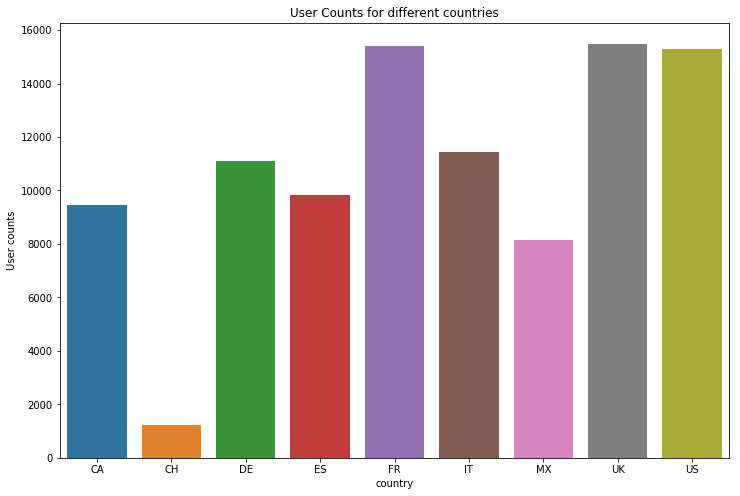

In [82]:
fig, ax = plt.subplots(figsize =(12,8))
sns.barplot(x = 'country', y = 'user_id', data= country_df)
plt.title('User Counts for different countries')
plt.ylabel('User counts')
plt.xlabel('country')
plt.show()

# Question 1:

## Financial metric: Revenue

In [6]:
avg_revenue_before= np.sum(df[df['date'] < '2015-10-31']['money_spent'])/len(df[df['date'] < '2015-10-31']['money_spent'])
avg_revenue_after= np.sum(df[df['date'] >= '2015-10-31']['money_spent'])/len(df[df['date'] >= '2015-10-31']['money_spent'])

In [7]:
avg_revenue_before

42.38178323229336

In [8]:
avg_revenue_after

46.88006

In [58]:
revenue_grouped = df.groupby(['date', 'is_referral'])['money_spent'].sum().reset_index()
revenue_grouped['date'] = revenue_grouped['date'].dt.strftime('%Y-%m-%d')

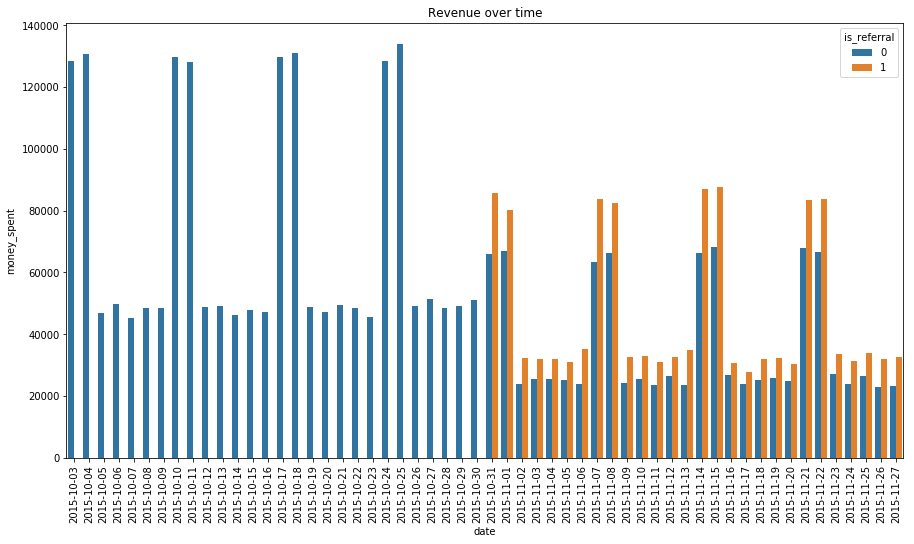

In [74]:
fig, ax = plt.subplots(figsize = (15,8))
sns.barplot(x ='date', y ='money_spent', hue= 'is_referral', data= revenue_grouped)
plt.xticks(rotation = 90)
plt.title('Revenue over time')
plt.show()

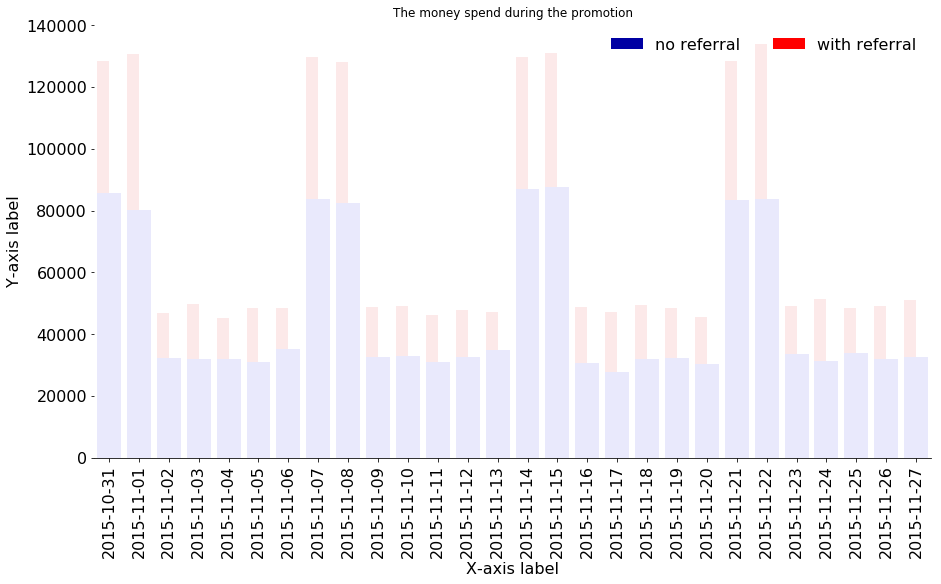

In [72]:
fig, ax = plt.subplots(figsize = (15,8))
#plot 1
sns.barplot(x ='date', y ='money_spent', hue= 'is_referral', data= revenue_grouped, color = "red")
#bottom plot
bottom_plot= sns.barplot(x ='date', y ='money_spent', hue= 'is_referral', data= revenue_grouped[revenue_grouped['is_referral'] ==1], color = "#0000A3")


topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['no referral', 'with referral'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Y-axis label")
bottom_plot.set_xlabel("X-axis label")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)
plt.xticks(rotation = 90)
plt.title('The money spend during the promotion')
plt.show()


In [11]:
df['rank'] = df.groupby('user_id')['date'].rank(method = 'first')

# Growth Metrics New users acqusition

In [17]:
# New users that came from referral program
len(df[(df['is_referral'] ==1) & (df['rank'] ==1)])

10391

In [21]:
df_day1 = df[df['rank'] ==1]
date_grouped = df_day1.groupby('date')['user_id'].count().reset_index()

In [32]:
date_grouped['date'] = date_grouped['date'].dt.strftime('%Y-%m-%d')

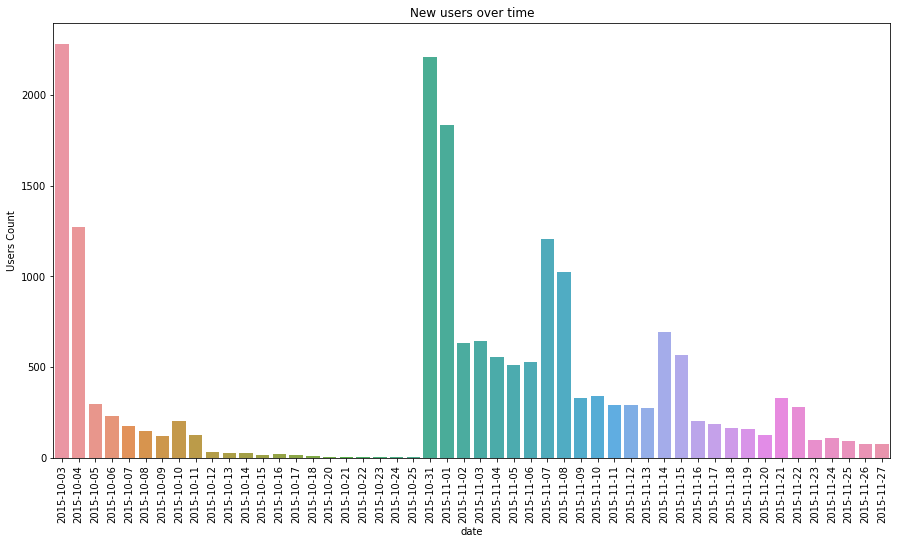

In [53]:
fig, ax = plt.subplots(figsize = (15,8))
sns.barplot(x = 'date', y = 'user_id', data = date_grouped)
plt.xticks(rotation=90)
plt.title('New users over time')
plt.xlabel('date')
plt.ylabel('Users Count')
#ax.axvline(pd.to_datetime('2015-10-31'), color='r', linestyle='--', lw=2)
plt.show()

## New users came from referral

In [43]:
grouped_df =df_day1.groupby(['date', 'is_referral'])['user_id'].count().reset_index()
grouped_df['date'] = grouped_df['date'].dt.strftime('%Y-%m-%d')

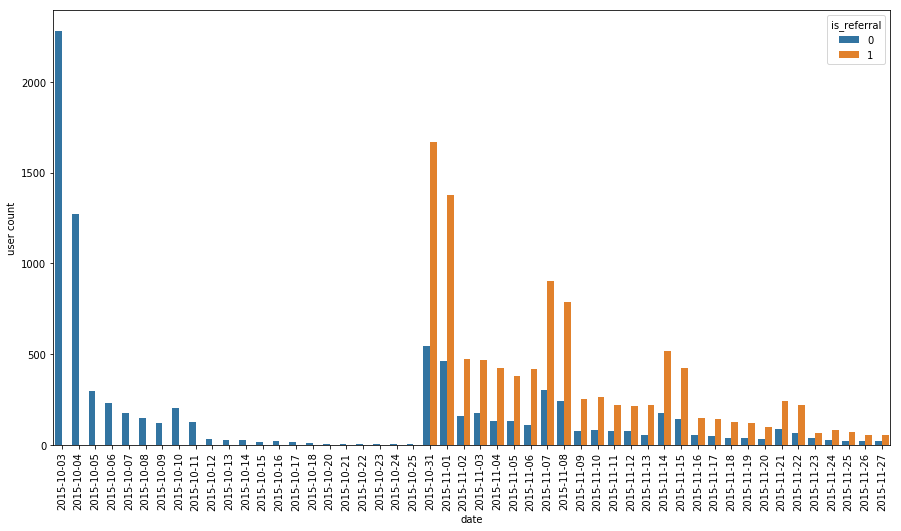

In [47]:
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(x = 'date', y ='user_id', hue = 'is_referral', data= grouped_df)
plt.xticks(rotation = 90)
plt.xlabel('date')
plt.ylabel('user count')

plt.show()

## DID

In [83]:
date_grouped = df.groupby('date')['money_spent'].sum().reset_index()

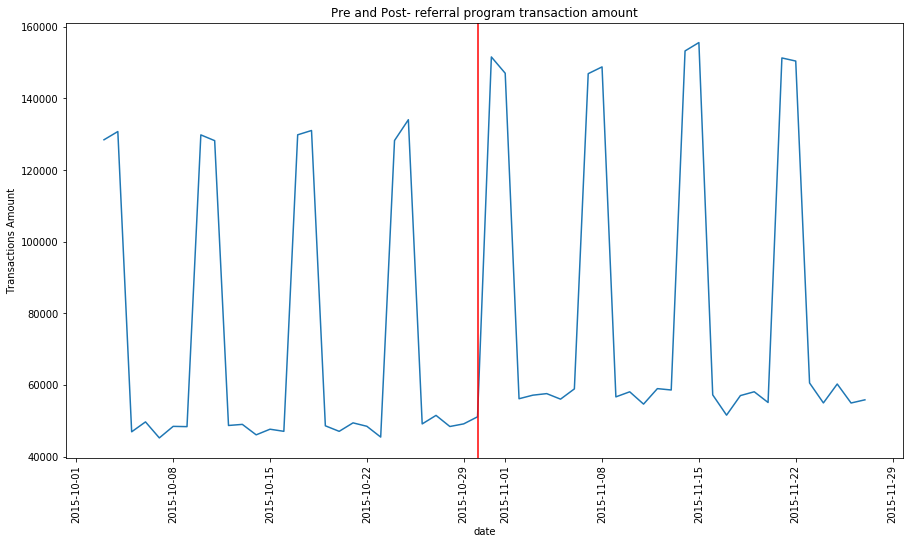

In [91]:
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(date_grouped['date'], date_grouped['money_spent'])
plt.xticks(rotation =90)
plt.axvline('2015-10-30', color ='red')
plt.ylabel('Transactions Amount')
plt.xlabel('date')
plt.title('Pre and Post- referral program transaction amount')
plt.show()

# Question 2:

I would suggest to make deeper investigation within these countries since they presented some differences for each country. Also I'd like to analyze the data after de-seasonlize. This current data presented strong seasonality.

In [131]:
def cal_statistics(df):
    pre_mean =np.sum(df[df['date'] < '2015-10-31']['money_spent'])/len(df[df['date'] < '2015-10-31']['money_spent'])
    post_mean = np.sum(df[df['date'] >= '2015-10-31']['money_spent'])/len(df[df['date'] >= '2015-10-31']['money_spent'])
    
    pre_test = df[df['date'] < '2015-10-31']['money_spent']
    post_test = df[df['date'] >= '2015-10-31']['money_spent']
    
    tests = ss.ttest_ind(pre_test, post_test, equal_var= False)
    
    pvalue = tests.pvalue / 2
    
    result = []
    
    result.append({'mean_pre': pre_mean, 'mean_post': post_mean, 'diff': post_mean-pre_mean, 'pvalue': pvalue})
    return pd.DataFrame(result).loc[:,['mean_pre','mean_post','diff','pvalue']]

In [132]:
cal_statistics(df)

,mean_pre,mean_post,diff,pvalue
0,42.381783,46.88006,4.498277,3.746117e-211


In [135]:
df.groupby('country').apply(cal_statistics)

,,mean_pre,mean_post,diff,pvalue
country,,,,,
CA,0,42.160484,49.252679,7.092195,2.264160e-43
CH,0,57.279627,59.976987,2.697360,6.377139e-02
DE,0,42.459846,48.854997,6.395151,3.231103e-39
ES,0,42.454276,44.527360,2.073084,2.391054e-08
FR,0,42.537595,44.600467,2.062872,7.389947e-12
IT,0,42.307267,44.722031,2.414764,6.287989e-12
MX,0,39.342841,42.885453,3.542612,2.128778e-13
UK,0,42.429595,49.116520,6.686926,9.524136e-65
US,0,42.230390,49.643303,7.412913,3.601599e-75


# Question 3:

A/B testing needs rigorous setting. It's essential that it's designed to test for one variant, which is the referral program. But this current setting, other variant might exists for example holidays. Also it might violate the SUTVA assumptions which is important for A/B testing. 